# Exploratory Data Analysis (EDA) dan Pembuatan Dataset Unbalanced

Notebook ini melakukan pengunduhan dataset dari Kaggle (`bittlingmayer/amazonreviews`), preprocessing untuk menghasilkan `amazon_reviews_processed.csv`, pembuatan dataset dengan distribusi kelas *unbalanced* (70% Positif, 20% Negatif, 10% Netral), visualisasi EDA, dan penyimpanan dataset *unbalanced* ke file CSV. File disimpan ke direktori lokal Colab dan Google Drive, dengan opsi untuk mengunduh langsung.


**Tujuan**:
- Mengunduh dataset dari Kaggle dan memprosesnya menjadi format CSV.
- Melakukan EDA untuk memahami distribusi kelas, panjang teks, dan frekuensi kata.
- Membuat dataset *unbalanced* sesuai kebutuhan.
- Menyimpan dataset untuk penggunaan selanjutnya (misalnya, pemodelan).

**Dataset**: `amazon_reviews_processed.csv` dengan kolom `text`, `label`, `score`, `sentiment`, `text_length`.


## 1. Persiapan Lingkungan

Instal library yang diperlukan dan impor modul.

In [2]:
!pip install kaggle wordcloud

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
from google.colab import files
import os
import zipfile
import bz2
import numpy as np
import nltk

# Download resource NLTK dengan pemeriksaan
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    # Verifikasi punkt_tab
    nltk.data.find('tokenizers/punkt_tab')
    print('Resource NLTK berhasil diunduh.')
except Exception as e:
    print(f'Error mengunduh resource NLTK: {e}')
    print('Mencoba mengunduh ulang punkt_tab...')
    nltk.download('punkt_tab', force=True)

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

Resource NLTK berhasil diunduh.


## 2. Mengatur dan Memverifikasi Kaggle API

Unggah file `kaggle.json` dan verifikasi autentikasi API.

In [3]:
def verify_kaggle_api():
    """Memverifikasi konfigurasi Kaggle API."""
    try:
        !kaggle datasets list -s "test" > /dev/null 2>&1
        print('Autentikasi Kaggle API berhasil.')
        return True
    except Exception as e:
        print(f'Error autentikasi Kaggle API: {e}')
        print('Pastikan file kaggle.json valid di ~/.kaggle/ dengan kunci "username" dan "key".')
        return False

def setup_kaggle_api():
    """Mengatur file kaggle.json untuk autentikasi."""
    try:
        if not os.path.exists('/root/.kaggle/kaggle.json'):
            print('Silakan unggah file kaggle.json Anda.')
            uploaded = files.upload()
            if 'kaggle.json' not in uploaded:
                raise FileNotFoundError('Harap unggah file kaggle.json yang valid.')
            os.makedirs('/root/.kaggle', exist_ok=True)
            with open('/root/.kaggle/kaggle.json', 'wb') as f:
                f.write(uploaded['kaggle.json'])
            os.chmod('/root/.kaggle/kaggle.json', 600)
            print('Kaggle API token berhasil diatur.')
        else:
            print('File kaggle.json sudah ada.')
        if not verify_kaggle_api():
            raise Exception('Verifikasi Kaggle API gagal.')
    except Exception as e:
        print(f'Error saat mengatur Kaggle API: {e}')
        raise

# Jalankan setup
setup_kaggle_api()

Silakan unggah file kaggle.json Anda.


Saving kaggle.json to kaggle.json
Kaggle API token berhasil diatur.
Autentikasi Kaggle API berhasil.


## 3. Mengunduh dan Memproses Dataset

Unduh dataset `bittlingmayer/amazonreviews`, ekstrak file, dan proses `train.ft.txt` menjadi `amazon_reviews_processed.csv`.

In [4]:
def download_kaggle_dataset():
    """Mengunduh dan mengekstrak dataset dari Kaggle."""
    dataset = 'bittlingmayer/amazonreviews'
    os.makedirs('./dataset', exist_ok=True)
    try:
        print(f'Mengunduh dataset {dataset}...')
        os.system(f'kaggle datasets download -d {dataset} -p ./dataset')
        zip_file = './dataset/amazonreviews.zip'
        if not os.path.exists(zip_file):
            raise FileNotFoundError('Gagal mengunduh amazonreviews.zip.')
        print(f'File ZIP {zip_file} berhasil diunduh.')

        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('./dataset')
        print('Dataset berhasil diekstrak.')

        # Tangani file terkompresi
        train_bz2 = './dataset/train.ft.txt.bz2'
        train_txt = './dataset/train.ft.txt'
        if os.path.exists(train_bz2):
            print('Menemukan train.ft.txt.bz2, mendekompresi...')
            with bz2.BZ2File(train_bz2, 'rb') as source, open(train_txt, 'wb') as dest:
                dest.write(source.read())
            print('Berhasil mendekompresi train.ft.txt.')
        elif not os.path.exists(train_txt):
            raise FileNotFoundError('File train.ft.txt tidak ditemukan setelah ekstraksi.')
        else:
            print('Menemukan train.ft.txt, melanjutkan.')
    except Exception as e:
        print(f'Error saat mengunduh atau mengekstrak dataset: {e}')
        raise

def load_and_preprocess_data():
    """Memuat dan memproses dataset dari train.ft.txt."""
    file_path = './dataset/train.ft.txt'
    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} tidak ditemukan.')

    reviews = []
    labels = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    if line.startswith('__label__'):
                        label, text = line.split(' ', 1)
                        label = 0 if label == '__label__1' else 1  # 0: Negatif, 1: Positif
                        reviews.append(text.strip())
                        labels.append(label)
                except ValueError:
                    continue
    except Exception as e:
        print(f'Error saat membaca file: {e}')
        raise

    # Buat DataFrame
    df = pd.DataFrame({'text': reviews, 'label': labels})

    # Tambahkan kolom score dan sentiment
    df['score'] = df['label'].apply(lambda x: np.random.choice([4, 5], p=[0.3, 0.7]) if x == 1 else np.random.choice([1, 2], p=[0.7, 0.3]))
    df['sentiment'] = df['score'].map({1: 'Negatif', 2: 'Negatif', 3: 'Netral', 4: 'Positif', 5: 'Positif'})
    df['text_length'] = df['text'].apply(lambda x: len(x.split()))

    # Tambah data Netral secara sintetis
    neutral_reviews = []
    for i in range(300):  # 300 ulasan Netral
        sample_text = df['text'].iloc[i % len(df)][:100] + '...'
        neutral_reviews.append({
            'text': sample_text,
            'label': 0,
            'score': 3,
            'sentiment': 'Netral',
            'text_length': len(sample_text.split())
        })
    df_neutral = pd.DataFrame(neutral_reviews)
    df = pd.concat([df, df_neutral], ignore_index=True)

    # Sampling untuk distribusi awal (750 Positif, 450 Negatif, 300 Netral)
    try:
        negatif = df[df['sentiment'] == 'Negatif'].sample(n=min(450, len(df[df['sentiment'] == 'Negatif'])), random_state=42)
        netral = df[df['sentiment'] == 'Netral'].sample(n=min(300, len(df[df['sentiment'] == 'Netral'])), random_state=42)
        positif = df[df['sentiment'] == 'Positif'].sample(n=min(750, len(df[df['sentiment'] == 'Positif'])), random_state=42)
        df_sampled = pd.concat([negatif, netral, positif], ignore_index=True)
        df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
        return df_sampled
    except Exception as e:
        print(f'Error saat sampling data: {e}')
        raise

# Cek jika dataset sudah ada
processed_file = 'amazon_reviews_processed.csv'
if os.path.exists(processed_file):
    print(f'Memuat dataset yang sudah ada dari {processed_file}...')
    df = pd.read_csv(processed_file)
else:
    try:
        download_kaggle_dataset()
        df = load_and_preprocess_data()
        df.to_csv(processed_file, index=False)
        print(f"Dataset berhasil diproses dan disimpan sebagai '{processed_file}'.")
    except Exception as e:
        print(f'Error selama proses: {e}')
        raise Exception('Gagal memproses dataset.')

# Tampilkan informasi dataset
print('\nInformasi Dataset:')
print(df.info())
print('\n5 Baris Pertama:')
print(df.head())
print('\nDistribusi Kelas Awal:')
print(df['sentiment'].value_counts())

Mengunduh dataset bittlingmayer/amazonreviews...
File ZIP ./dataset/amazonreviews.zip berhasil diunduh.
Dataset berhasil diekstrak.
Menemukan train.ft.txt.bz2, mendekompresi...
Berhasil mendekompresi train.ft.txt.
Dataset berhasil diproses dan disimpan sebagai 'amazon_reviews_processed.csv'.

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1500 non-null   object
 1   label        1500 non-null   int64 
 2   score        1500 non-null   int64 
 3   sentiment    1500 non-null   object
 4   text_length  1500 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 58.7+ KB
None

5 Baris Pertama:
                                                text  label  score sentiment  \
0  Excellent Program for the Money: I had been us...      1      5   Positif   
1  Pretty good: I've tried a few different trash ...      1 

## 4. Membuat Dataset Unbalanced

Buat dataset dengan distribusi kelas *unbalanced* (70% Positif, 20% Negatif, 10% Netral).

In [5]:
def create_unbalanced_dataset(df, target_dist={'Positif': 0.7, 'Negatif': 0.2, 'Netral': 0.1}, total_samples=1500):
    """Membuat dataset dengan distribusi kelas unbalanced."""
    try:
        # Periksa jumlah data per kelas
        class_counts = df['sentiment'].value_counts()
        print('Jumlah data per kelas sebelum sampling:')
        print(class_counts)

        # Hitung jumlah sampel per kelas
        samples_per_class = {k: int(v * total_samples) for k, v in target_dist.items()}
        print('Jumlah sampel yang diminta:', samples_per_class)

        # Sesuaikan jumlah sampel berdasarkan data yang tersedia
        for sentiment in samples_per_class:
            available = len(df[df['sentiment'] == sentiment])
            if samples_per_class[sentiment] > available:
                print(f'Peringatan: Hanya {available} data tersedia untuk {sentiment}, '
                      f'menggunakan sampling dengan penggantian.')

        # Sampling dengan penyesuaian
        df_positif = df[df['sentiment'] == 'Positif'].sample(
            n=samples_per_class['Positif'],
            replace=True,  # Oversampling untuk Positif
            random_state=42
        )
        df_negatif = df[df['sentiment'] == 'Negatif'].sample(
            n=samples_per_class['Negatif'],
            replace=len(df[df['sentiment'] == 'Negatif']) < samples_per_class['Negatif'],
            random_state=42
        )
        df_netral = df[df['sentiment'] == 'Netral'].sample(
            n=samples_per_class['Netral'],
            replace=len(df[df['sentiment'] == 'Netral']) < samples_per_class['Netral'],
            random_state=42
        )

        # Gabungkan dan acak
        df_unbalanced = pd.concat([df_positif, df_negatif, df_netral], ignore_index=True)
        df_unbalanced = df_unbalanced.sample(frac=1, random_state=42).reset_index(drop=True)

        # Verifikasi distribusi
        print('Distribusi kelas setelah pengaturan unbalanced:')
        print(df_unbalanced['sentiment'].value_counts())
        print('\nProporsi kelas:')
        print(df_unbalanced['sentiment'].value_counts(normalize=True))

        return df_unbalanced
    except Exception as e:
        print(f'Error saat membuat dataset unbalanced: {e}')
        return None

# Buat dataset unbalanced
df_unbalanced = create_unbalanced_dataset(df)

# Verifikasi
if df_unbalanced is None:
    print('Gagal membuat dataset unbalanced. Proses dihentikan.')
    raise Exception('Proses dihentikan karena gagal membuat dataset unbalanced.')
else:
    print('Dataset unbalanced berhasil dibuat.')

Jumlah data per kelas sebelum sampling:
sentiment
Positif    750
Negatif    450
Netral     300
Name: count, dtype: int64
Jumlah sampel yang diminta: {'Positif': 1050, 'Negatif': 300, 'Netral': 150}
Peringatan: Hanya 750 data tersedia untuk Positif, menggunakan sampling dengan penggantian.
Distribusi kelas setelah pengaturan unbalanced:
sentiment
Positif    1050
Negatif     300
Netral      150
Name: count, dtype: int64

Proporsi kelas:
sentiment
Positif    0.7
Negatif    0.2
Netral     0.1
Name: proportion, dtype: float64
Dataset unbalanced berhasil dibuat.


## 5. Melakukan EDA pada Dataset Unbalanced

Lakukan EDA untuk memahami distribusi kelas, panjang teks, frekuensi kata, dan korelasi pada dataset *unbalanced*.

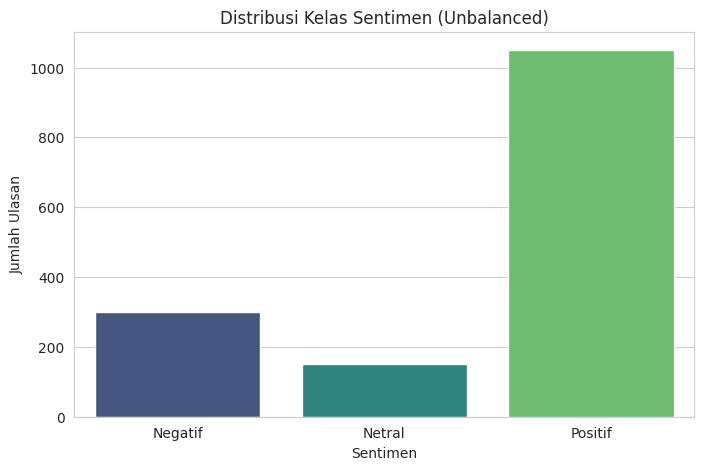

Jumlah data per kelas (unbalanced):
sentiment
Positif    1050
Negatif     300
Netral      150
Name: count, dtype: int64


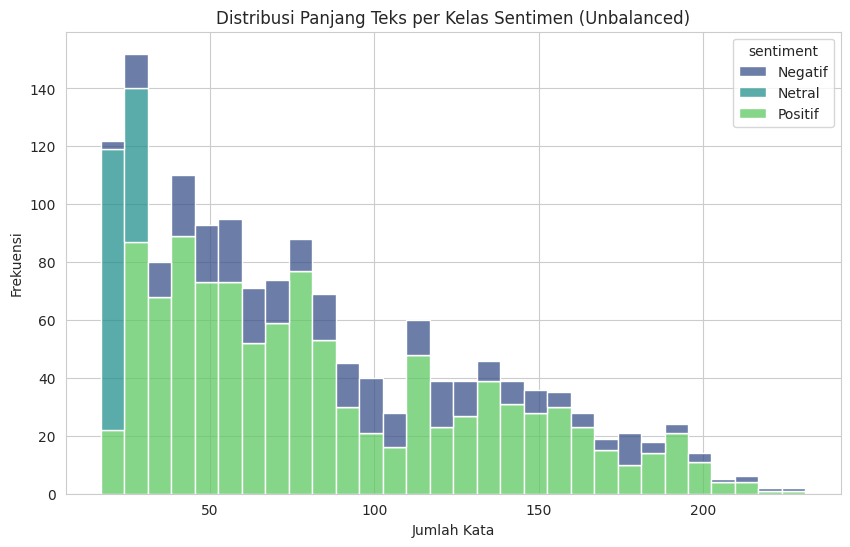

Statistik panjang teks (unbalanced):
            count       mean        std   min   25%   50%     75%    max
sentiment                                                               
Negatif     300.0  94.166667  47.354412  20.0  54.0  88.0  123.25  231.0
Netral      150.0  23.246667   2.719398  17.0  21.0  23.0   25.00   31.0
Positif    1050.0  86.203810  48.797674  22.0  45.0  75.0  123.00  224.0


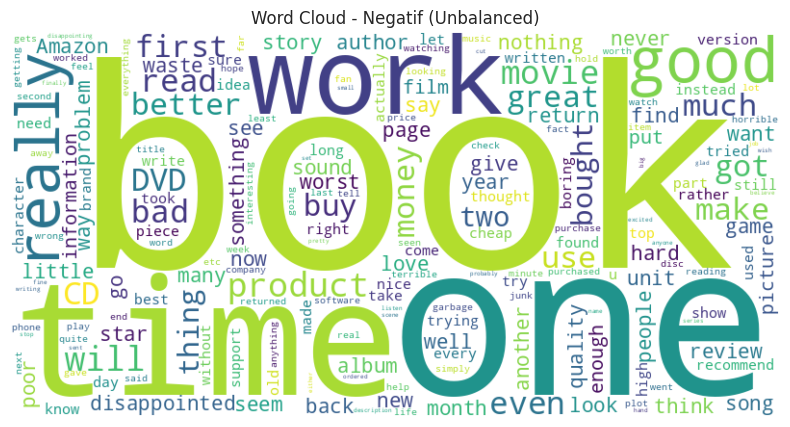

Kata teratas untuk Negatif (unbalanced):
[('book', 186), ('one', 104), ('would', 98), ('like', 86), ('get', 66), ('time', 66), ('good', 63), ('product', 58), ('really', 58), ('better', 53)]


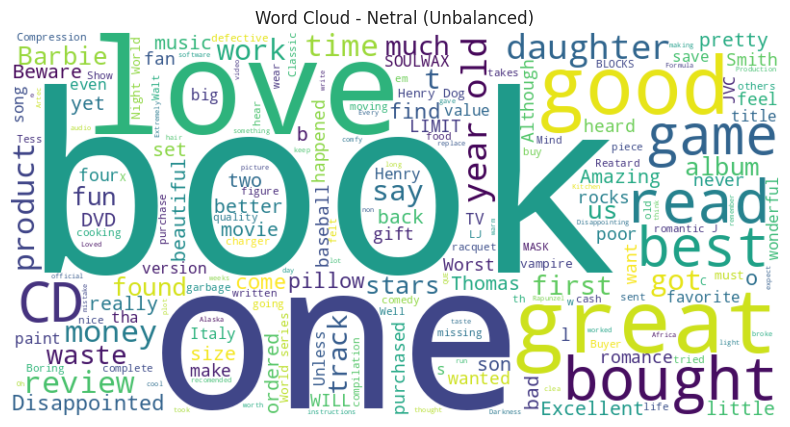

Kata teratas untuk Netral (unbalanced):
[('book', 28), ('one', 20), ('great', 15), ('good', 12), ('bought', 12), ('read', 12), ('old', 12), ('best', 10), ('game', 10), ('year', 10)]


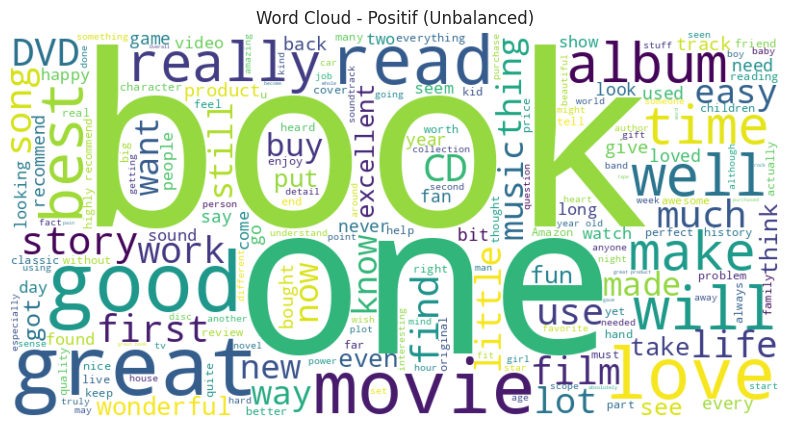

Kata teratas untuk Positif (unbalanced):
[('book', 511), ('one', 430), ('great', 430), ('good', 401), ('like', 250), ('movie', 246), ('love', 245), ('well', 224), ('read', 223), ('get', 194)]


<ipython-input-6-56c92bb0ab3e>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='text_length', data=df_unbalanced, order=['Negatif', 'Netral', 'Positif'], palette='viridis')


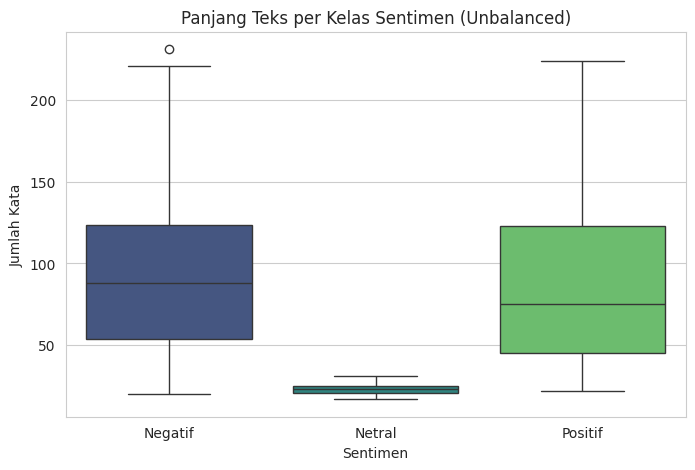

In [6]:
def perform_eda(df_unbalanced):
    """Melakukan Exploratory Data Analysis pada dataset unbalanced."""
    # 5.1 Distribusi Kelas
    plt.figure(figsize=(8, 5))
    sns.countplot(x='sentiment', hue='sentiment', data=df_unbalanced, order=['Negatif', 'Netral', 'Positif'], palette='viridis', legend=False)
    plt.title('Distribusi Kelas Sentimen (Unbalanced)')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah Ulasan')
    plt.show()

    print("Jumlah data per kelas (unbalanced):")
    print(df_unbalanced['sentiment'].value_counts())

    # 5.2 Panjang Teks
    df_unbalanced['text_length'] = df_unbalanced['text'].apply(lambda x: len(word_tokenize(x)))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_unbalanced, x='text_length', hue='sentiment', multiple='stack', bins=30, palette='viridis')
    plt.title('Distribusi Panjang Teks per Kelas Sentimen (Unbalanced)')
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Frekuensi')
    plt.show()

    print("Statistik panjang teks (unbalanced):")
    print(df_unbalanced.groupby('sentiment')['text_length'].describe())

    # 5.3 Frekuensi Kata
    def get_top_words(texts, n=10):
        stop_words = set(stopwords.words('english'))
        all_words = []
        for text in texts:
            words = word_tokenize(text.lower())
            words = [word for word in words if word.isalpha() and word not in stop_words]
            all_words.extend(words)
        return Counter(all_words).most_common(n)

    # Word Cloud dan Frekuensi Kata per Kelas
    for sentiment in ['Negatif', 'Netral', 'Positif']:
        texts = df_unbalanced[df_unbalanced['sentiment'] == sentiment]['text']
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(texts))

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud - {sentiment} (Unbalanced)')
        plt.axis('off')
        plt.show()

        print(f"Kata teratas untuk {sentiment} (unbalanced):")
        print(get_top_words(texts, 10))

    # 5.4 Korelasi Panjang Teks dan Sentimen
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='sentiment', y='text_length', data=df_unbalanced, order=['Negatif', 'Netral', 'Positif'], palette='viridis')
    plt.title('Panjang Teks per Kelas Sentimen (Unbalanced)')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah Kata')
    plt.show()

# Jalankan EDA
perform_eda(df_unbalanced)

## 6. Menyimpan Dataset Unbalanced

Simpan dataset *unbalanced* ke file CSV di direktori lokal Colab dan Google Drive.

In [7]:
def save_unbalanced_data(df_unbalanced, local_path='amazon_reviews_unbalanced.csv', drive_path='/content/drive/MyDrive/amazon_reviews_unbalanced.csv'):
    """Menyimpan dataset unbalanced ke lokal dan Google Drive."""
    if df_unbalanced is None:
        print("Tidak ada dataset untuk disimpan.")
        return

    # Simpan ke direktori lokal
    try:
        df_unbalanced.to_csv(local_path, index=False)
        print(f"Dataset unbalanced berhasil disimpan ke {local_path}")
        if os.path.exists(local_path):
            print(f"File {local_path} terdeteksi, ukuran: {os.path.getsize(local_path)} bytes")
        else:
            print(f"Error: File {local_path} tidak ditemukan.")
    except Exception as e:
        print(f"Error saat menyimpan ke lokal: {e}")

    # Simpan ke Google Drive
    try:
        drive.mount('/content/drive', force_remount=True)
        df_unbalanced.to_csv(drive_path, index=False)
        print(f"Dataset unbalanced berhasil disimpan ke Google Drive: {drive_path}")
        if os.path.exists(drive_path):
            print(f"File {drive_path} terdeteksi, ukuran: {os.path.getsize(drive_path)} bytes")
        else:
            print(f"Error: File {drive_path} tidak ditemukan.")
    except Exception as e:
        print(f"Error saat menyimpan ke Google Drive: {e}")

    # Opsi unduhan
    download_option = input("Apakah Anda ingin mengunduh file CSV unbalanced? (y/n): ")
    if download_option.lower() == 'y':
        files.download(local_path)
        print(f"File {local_path} diunduh.")

# Simpan dataset
save_unbalanced_data(df_unbalanced)

Dataset unbalanced berhasil disimpan ke amazon_reviews_unbalanced.csv
File amazon_reviews_unbalanced.csv terdeteksi, ukuran: 603564 bytes
Mounted at /content/drive
Dataset unbalanced berhasil disimpan ke Google Drive: /content/drive/MyDrive/amazon_reviews_unbalanced.csv
File /content/drive/MyDrive/amazon_reviews_unbalanced.csv terdeteksi, ukuran: 603564 bytes
Apakah Anda ingin mengunduh file CSV unbalanced? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File amazon_reviews_unbalanced.csv diunduh.
